<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Research-Question" data-toc-modified-id="Research-Question-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Research Question</a></span></li><li><span><a href="#Data-preperation" data-toc-modified-id="Data-preperation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preperation</a></span></li><li><span><a href="#Build-the-network" data-toc-modified-id="Build-the-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build the network</a></span><ul class="toc-item"><li><span><a href="#Complete-Network" data-toc-modified-id="Complete-Network-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Complete Network</a></span></li><li><span><a href="#topN-Stations-Network" data-toc-modified-id="topN-Stations-Network-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>topN Stations Network</a></span></li></ul></li><li><span><a href="#Analyze-the-network" data-toc-modified-id="Analyze-the-network-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyze the network</a></span></li><li><span><a href="#Louvain-commmunity-detection" data-toc-modified-id="Louvain-commmunity-detection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Louvain commmunity detection</a></span></li><li><span><a href="#References:" data-toc-modified-id="References:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References:</a></span></li></ul></div>

# Bike Network Analysis

## Research Question

- Where do people return more bikes than they take with? Rebalancing issue: Differences between indegree and outdegree per day, week, year?
- From what to what station are bikes more likely returned (community detection)?

## Data preperation

In [32]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import os, sys
os.chdir("..")
sys.path.append(os.getcwd())

In [71]:
from preprocessor.network_builder import NetworkBuilder
from preprocessor.map_builder import MapBuilder
import networkx as nx
import community as community_louvain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import contextily as ctx
import seaborn as sns

sns.set("poster")
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
network_builder = NetworkBuilder()
nodes, edges = network_builder.nodes, network_builder.edges
xmin, xmax, ymin, ymax = network_builder.min_max_nodes
geodata_nyc = MapBuilder().data

## Build the network
### Complete Network

In [284]:
margin = 1000
xmin = min([tpl[0] for tpl in nodes.values()])-margin
ymin = min([tpl[1] for tpl in nodes.values()])-margin
xmax = max([tpl[0] for tpl in nodes.values()])+margin
ymax = max([tpl[1] for tpl in nodes.values()])+margin

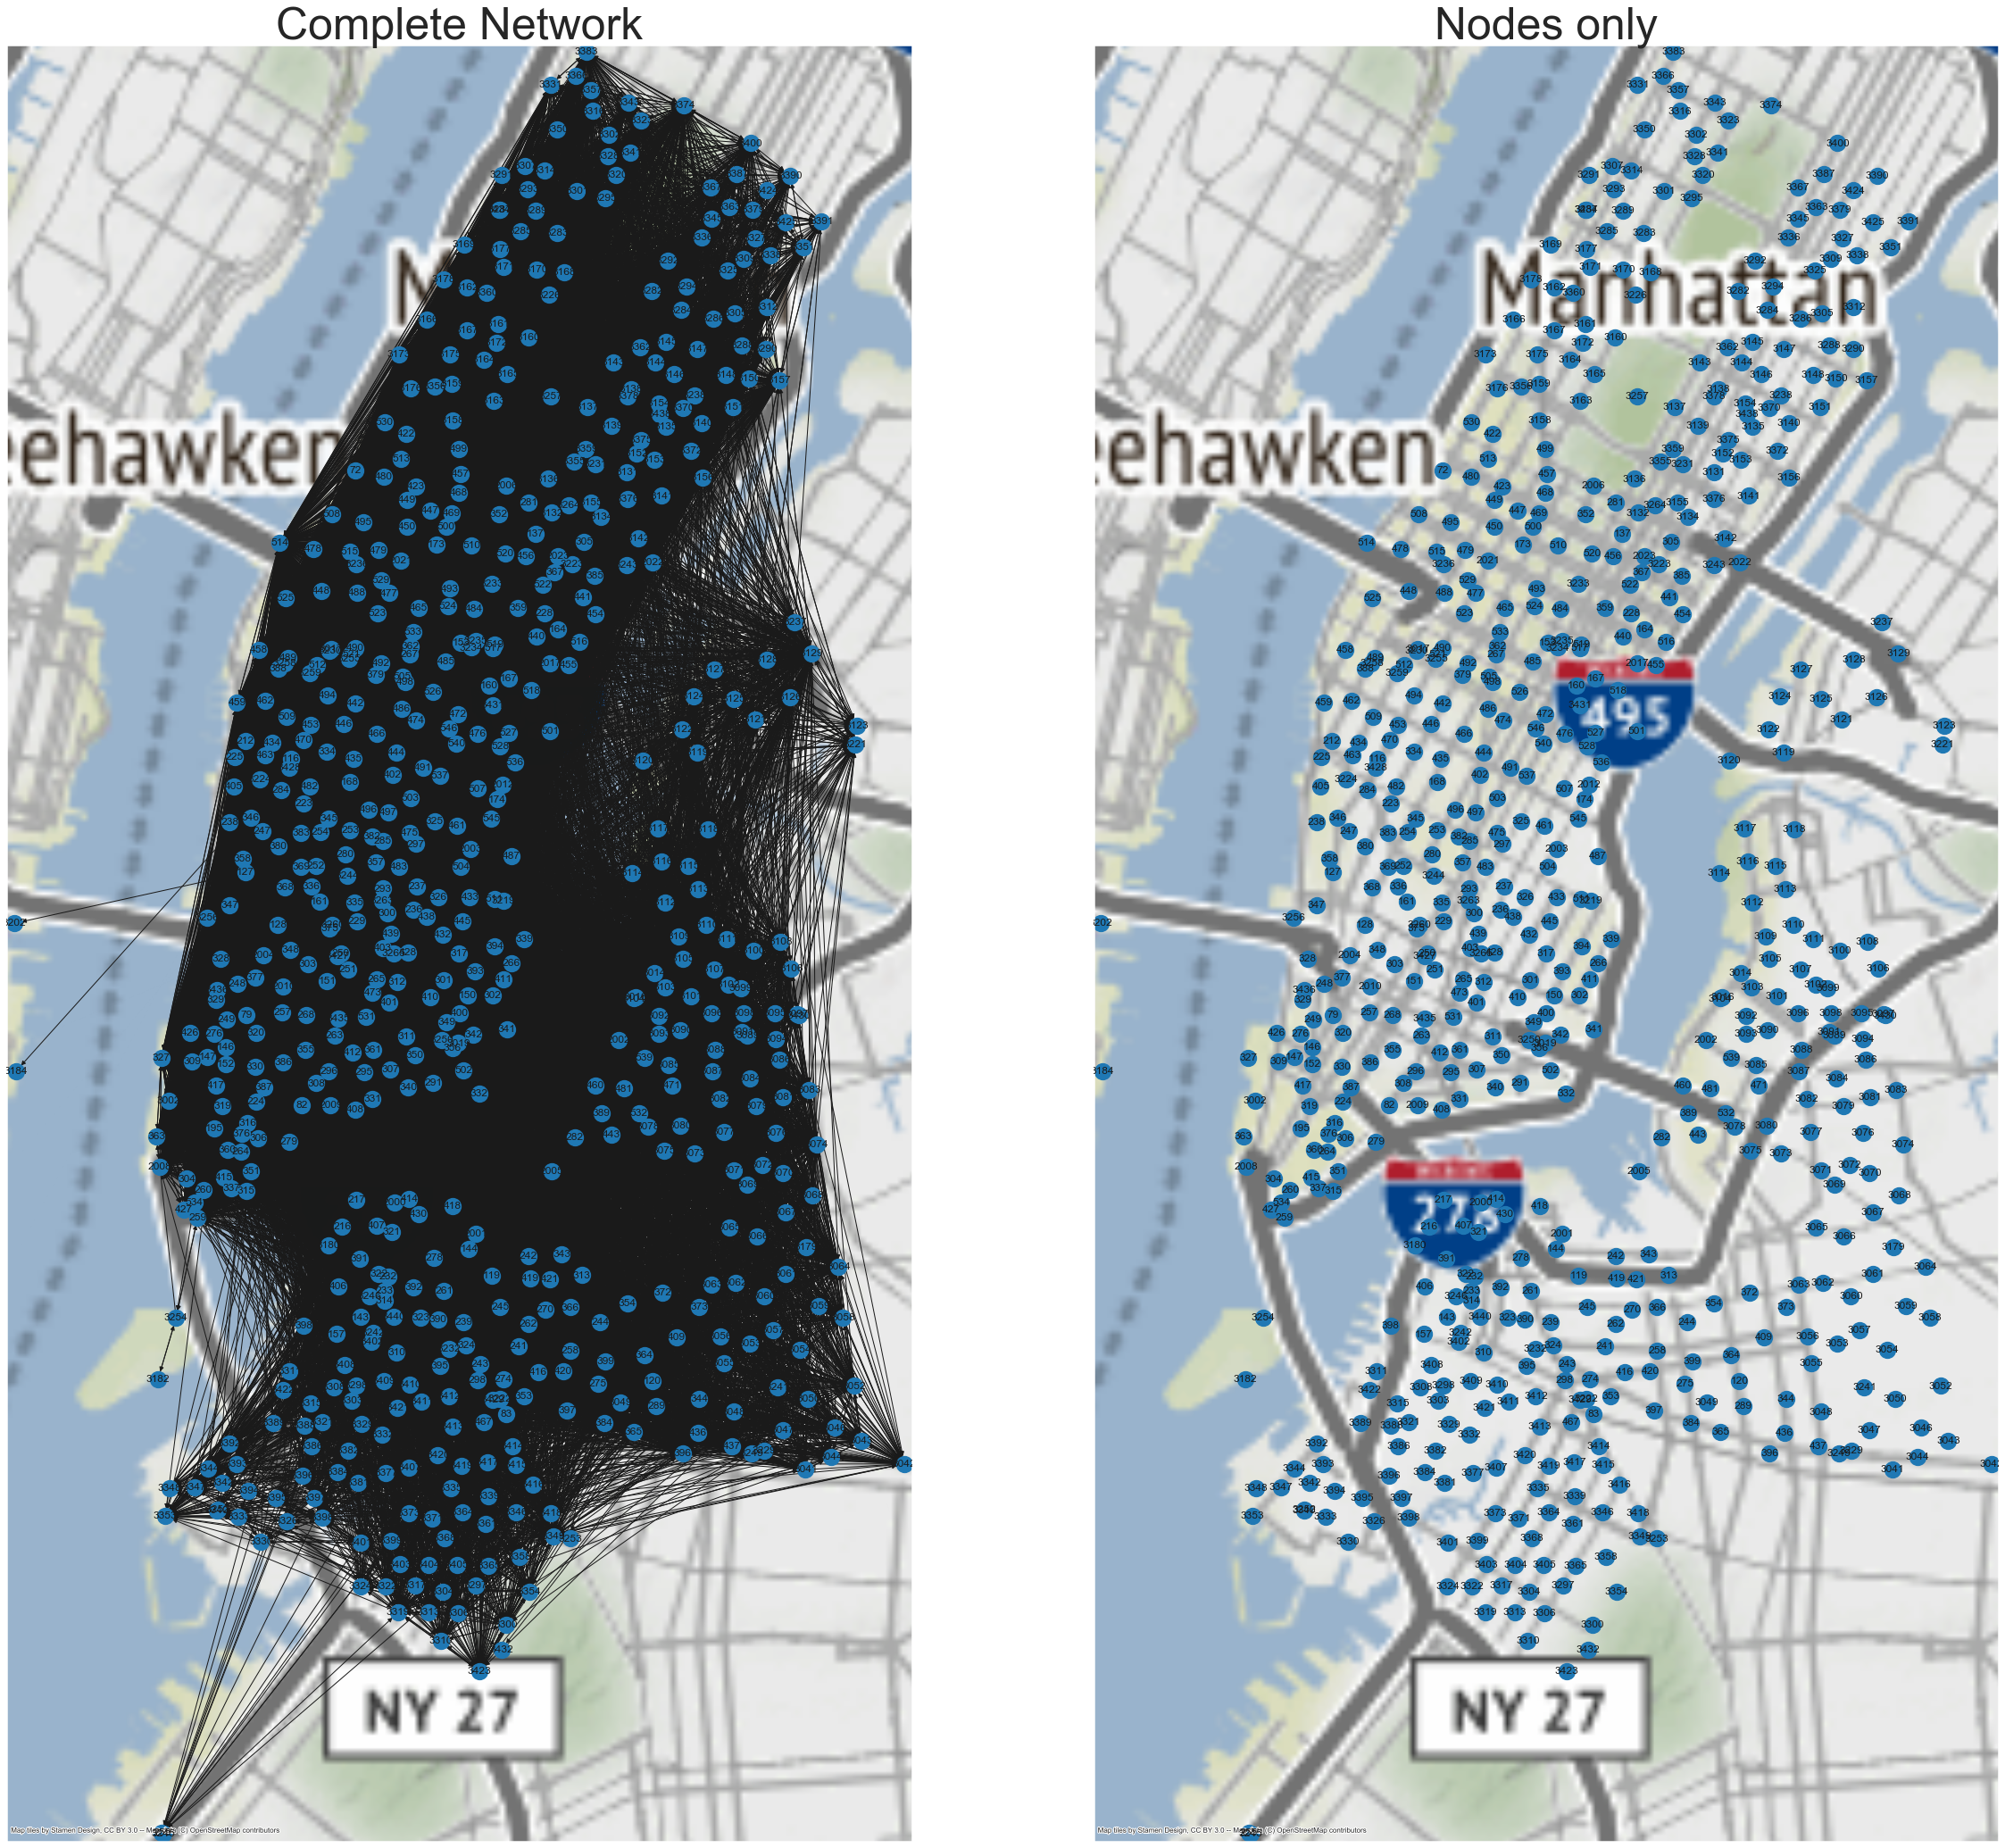

In [27]:
# plot the network
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40,40), sharey=True)

# complete network
G1 = nx.DiGraph()
G1.add_nodes_from(nodes)
G1.add_edges_from(edges)

axes[0].set_title("Complete Network", fontsize=50)
basemap0 = geodata_nyc.plot(alpha=0, ax=axes[0])
ctx.add_basemap(basemap0)
nx.draw_networkx(G1, ax=axes[0], pos=nodes)

# nodes only
G2 = nx.DiGraph()
G2.add_nodes_from(nodes)

axes[1].set_title("Nodes only", fontsize=50, )

basemap1 = geodata_nyc.plot(alpha=0, ax=axes[1])
ctx.add_basemap(basemap1)
nx.draw_networkx(G2, ax=axes[1], pos=nodes)

for ax in axes[0], axes[1]:
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


plt.show()

### topN Stations Network

In [10]:
centrality_indegree = nx.in_degree_centrality(G1)
sorted_stations = sorted(centrality_indegree.items(),
                         key=lambda x: x[1],
                         reverse=True)

N = 30
top_stations = set([x[0] for x in sorted_stations[0:N]])

nodes_topN = {key: value for (key,value) 
               in nodes.items() 
               if key in top_stations}

edges_topN = [tuple for tuple 
               in edges 
               if (tuple[0] in top_stations) & 
               (tuple[1] in top_stations)]

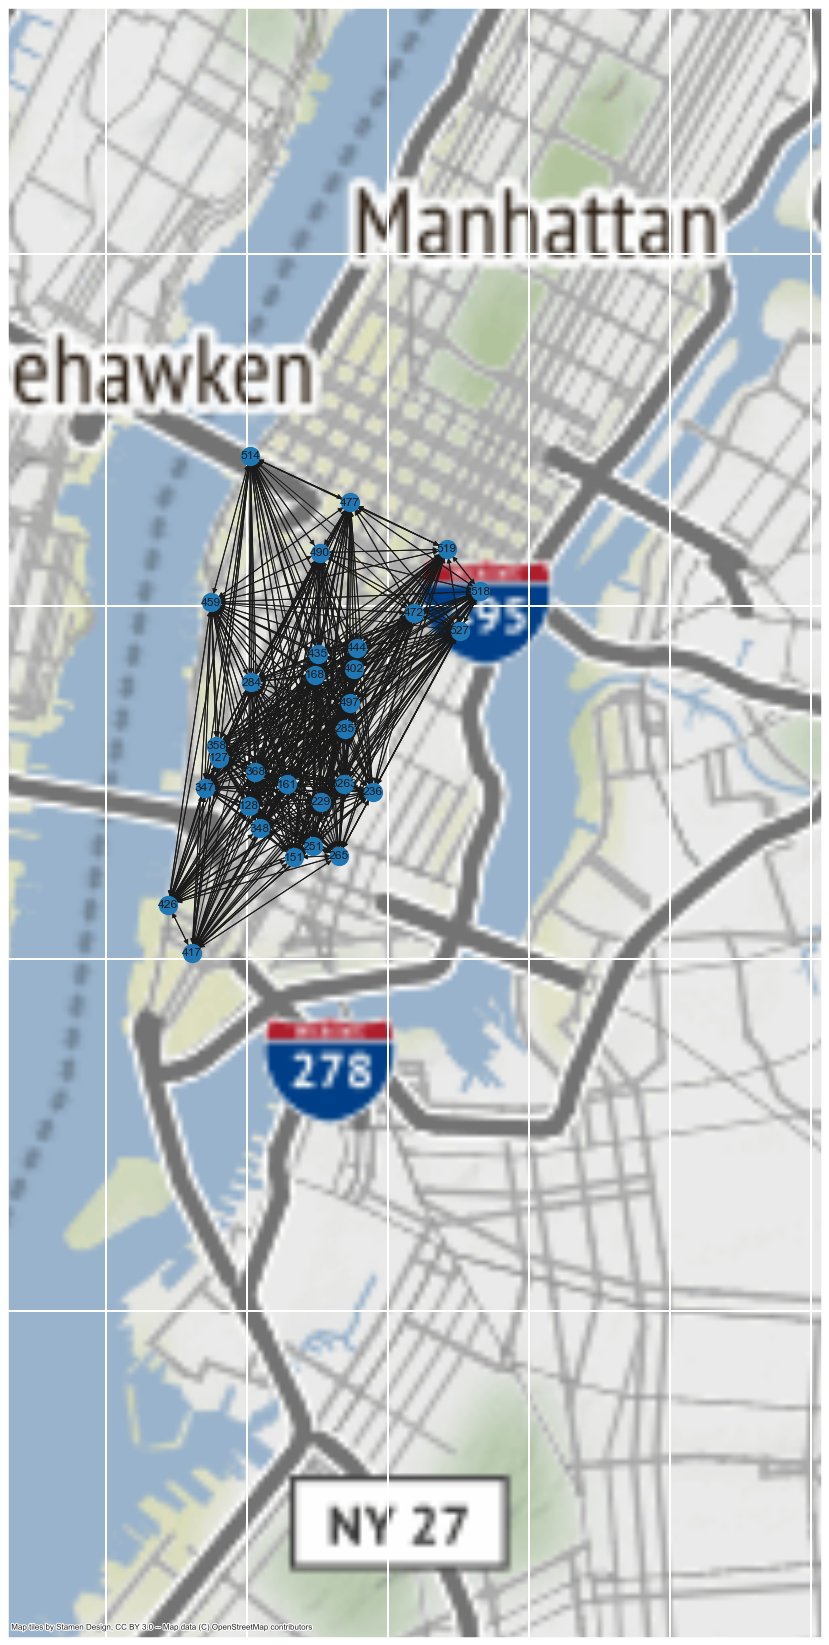

In [18]:
G3 = nx.DiGraph()
G3.add_nodes_from(nodes_topN)
G3.add_edges_from(edges_topN)

fig, ax = plt.subplots(figsize=(30,30))

# add open street map of NYC as basemap to Networkx graph
basemap = geodata_nyc.plot(alpha=0, edgecolor="k", ax=ax)
ctx.add_basemap(basemap)

# add Networkx graph
nx.draw_networkx(G3, ax=ax, pos=nodes_topN)

plt.xlim((xmin, xmax))
plt.ylim((ymin, ymax))

plt.show()

## Analyze the network

In [34]:
degree_centrality = nx.degree_centrality(G1)
indegree_centrality = nx.in_degree_centrality(G1)
outdegree_centrality = nx.out_degree_centrality(G1)

In [100]:
def to_dataframe(centrality_measure):
    return pd.DataFrame.from_dict(data=centrality_measure, orient="index")

In [103]:
centrality = pd.concat([to_dataframe(degree_centrality),
                        to_dataframe(indegree_centrality),
                        to_dataframe(outdegree_centrality)],
                       axis=1)
centrality.columns = ["degree_centrality", "indegree_centrality", "outdegree_centrality"]
centrality

degree_centrality  indegree_centrality  outdegree_centrality
72             0.624806             0.316279              0.308527
79             0.576744             0.313178              0.263566
82             0.305426             0.148837              0.156589
83             0.443411             0.229457              0.213953
116            0.691473             0.355039              0.336434
...                 ...                  ...                   ...
3434           0.136434             0.072868              0.063566
3435           0.432558             0.206202              0.226357
3436           0.263566             0.127132              0.136434
3438           0.072868             0.032558              0.040310
3440           0.031008             0.017054              0.013953

[646 rows x 3 columns]

In [52]:
centrality_measures = dict([degree_centrality, indegree_centrality, outdegree_centrality])

ValueError: dictionary update sequence element #0 has length 646; 2 is required

In [50]:
centrality_measures

{72: 0.3085271317829457,
 79: 0.26356589147286824,
 82: 0.15658914728682172,
 83: 0.21395348837209302,
 116: 0.3364341085271318,
 119: 0.043410852713178294,
 120: 0.12093023255813953,
 127: 0.3643410852713178,
 128: 0.40310077519379844,
 137: 0.2496124031007752,
 143: 0.17984496124031008,
 144: 0.11627906976744186,
 146: 0.2682170542635659,
 147: 0.351937984496124,
 150: 0.2682170542635659,
 151: 0.4511627906976744,
 152: 0.2558139534883721,
 153: 0.3767441860465116,
 157: 0.19224806201550387,
 160: 0.10852713178294573,
 161: 0.3705426356589147,
 164: 0.34728682170542635,
 167: 0.386046511627907,
 168: 0.40930232558139534,
 173: 0.3767441860465116,
 174: 0.3426356589147287,
 195: 0.3364341085271318,
 212: 0.3457364341085271,
 216: 0.07286821705426356,
 217: 0.23255813953488372,
 223: 0.2186046511627907,
 224: 0.2868217054263566,
 225: 0.31317829457364343,
 228: 0.3178294573643411,
 229: 0.3953488372093023,
 232: 0.15968992248062014,
 233: 0.06821705426356589,
 236: 0.4294573643410853,


In [47]:
pd.DataFrame.from_dict(data=centrality_measures, orient="index")

AttributeError: 'list' object has no attribute 'values'

In [25]:
#3) Analysis and Visualization: 
    
#Some high level stats for the network:
     
print('# of edges: {}'.format(G1.number_of_edges())) #~147k
print('# of nodes: {}'.format(G1.number_of_nodes())) #336 nodes, matches number of stations
# print(G1.degree(node_data_final['station_id'])) #look at most important nodes in network
print(nx.in_degree_centrality(G1)) #computes the in-degree centrality for nodes in the directed network
print(nx.out_degree_centrality(G1)) #coputes the out-degree centrality for nodes in the directed network


# of edges: 81053
# of nodes: 646
{72: 0.31627906976744186, 79: 0.31317829457364343, 82: 0.14883720930232558, 83: 0.22945736434108527, 116: 0.3550387596899225, 119: 0.04186046511627907, 120: 0.10387596899224806, 127: 0.39689922480620154, 128: 0.41860465116279066, 137: 0.2558139534883721, 143: 0.1875968992248062, 144: 0.13333333333333333, 146: 0.26666666666666666, 147: 0.351937984496124, 150: 0.23565891472868217, 151: 0.47131782945736433, 152: 0.2744186046511628, 153: 0.36589147286821705, 157: 0.2062015503875969, 160: 0.09612403100775194, 161: 0.413953488372093, 164: 0.30077519379844964, 167: 0.3643410852713178, 168: 0.3922480620155039, 173: 0.3612403100775194, 174: 0.33488372093023255, 195: 0.35348837209302325, 212: 0.351937984496124, 216: 0.05116279069767442, 217: 0.22325581395348837, 223: 0.23410852713178293, 224: 0.2496124031007752, 225: 0.33798449612403103, 228: 0.2651162790697674, 229: 0.4248062015503876, 232: 0.14883720930232558, 233: 0.06046511627906977, 236: 0.3953488372093023,

- Structural features
    - Density: How many of the possible ties are present in the network?
    - Reciprocity: How many of the dyads are mutual? (only makes sense in directed networks)
    - Clustering: How many of the triads are "closed"? (i.e. don't have null dyads → triangles)
    - Centrality: Centrality,	i.e.	how	much each actor is "in the center" of a network	is one of the key concepts in network analysis

In [21]:
density = nx.density(G1)
reciprocity = nx.reciprocity(G1)
clustering_coefficient = nx.average_clustering(G1)

* Which centrality measure is appropriate?
    * Degree Centrality: How many edges does a node have?
    * Closeness: How short are the distances to all other nodes? 
    * Betweenness: How many shortest paths go through a certain node?
    * Eigenvector (Bonacich) Centrality: A node has central neighbours

In [22]:
centrality_indegree = nx.in_degree_centrality(G1)
centrality_outdegree = nx.out_degree_centrality(G1)
centrality_betweenness = nx.betweenness_centrality(G1)
centrality_eigenvector = nx.eigenvector_centrality(G1)

In [12]:
print(f"{nx.info(G1)}")

Name: 
Type: DiGraph
Number of nodes: 646
Number of edges: 81053
Average in degree: 125.4690
Average out degree: 125.4690


For directed networks, there are two measures of degree. In-degree is the number of connections that point inward at a vertex. Out-degree is the number of connections that originate at a vertex and point outward to other vertices.

In [ ]:
# G.number_of_nodes()
# G.number_of_edges()

# in degree -> end station (return)
# out degree -> start station (pick-up)
# out degree - in degree => different colors

In [ ]:
## notice that there're self-loops
#print(G.edges(data = True)[:4])
#print()
#
## examine the density (the proportion of nodes that are connected)
#num_edges = len(G.edges())
#num_possible_edges = len(G.nodes()) ** 2
#density = num_edges / num_possible_edges
#print('density:', density)

In [ ]:
# basic descriptives
# density

In [ ]:
sorted_stations = sorted(centrality_indegree.items(),
                         key=lambda x: x[1],
                         reverse=True)
top10_stations = set([x[0] for x in sorted_stations[0:10]])
top10_stations

# Creating a list of degree, closeness, pagerank and betweenness centrality
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
pagerank = nx.pagerank(G, weight="weight")
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

centrality_measures = [
    degree_centrality, closeness_centrality, pagerank, betweenness_centrality
]

In [ ]:
# graph plot, weight = counts / duration
# graph dependend on week day (Mo-Fr vs. Sa-Su) / season (summer vs winter)

## Louvain commmunity detection

In [298]:
# Find community structure that has the maximal modularity
uG1 = G1.to_undirected()
partition = community_louvain.best_partition(uG1, random_state=80)
modularity = community_louvain.modularity(partition, uG1)
modularity

0.27822164182305487

In [299]:
# list of partition values
partition_values = list(partition.values())
n_unique_partition_values = len(set(partition_values))

# list of corresponding colors
color_palette = sns.color_palette(palette="deep", n_colors=n_unique_partition_values)
array_color_palette = np.array(color_palette)
#sns.palplot(color_palette)

# replace partion values with color values
node_color = [color_palette[i] for i in partition_values]

In [303]:
node_list = [nodeid for nodeid in partition if partition[nodeid] == 0]
#df_partition = pd.DataFrame.from_dict(partition, orient="index")
labels = {
    387:387,
    412:412,
#    3129:3129,
    3182:3182, 
    3245:3245, 
    3250:3250, 
    3254:3254, 
    3371:3371
}

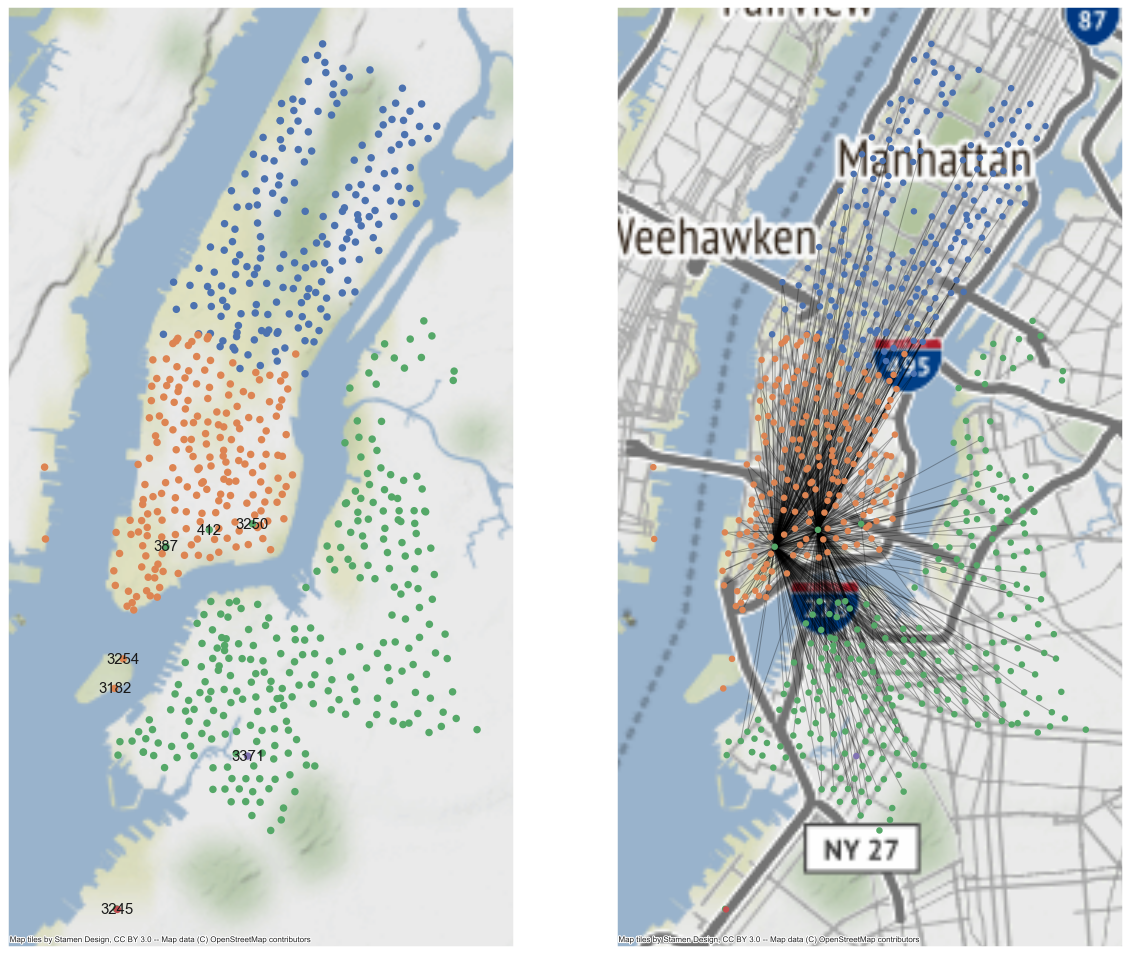

In [312]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

# add open street map of NYC as basemap to Networkx graph
basemap = geodata_nyc.plot(alpha=0, edgecolor="k", ax=axes[0])
ctx.add_basemap(basemap, source=ctx.providers.Stamen.TerrainBackground)

# add Networkx graph
nx.draw_networkx_nodes(uG1, ax=axes[0], pos=nodes, node_size=30, node_color=node_color, with_labels = True)
nx.draw_networkx_labels(uG1, ax=axes[0], pos=nodes, font_size=15, labels=labels, nodelist=nodelist)

# look at the edges from and to these outlier stations
basemap = geodata_nyc.plot(alpha=0, edgecolor="k", ax=axes[1])
ctx.add_basemap(basemap)

# add Networkx graph
#nx.draw_networkx(uG1, ax=ax, pos=nodes, node_size=10, node_color=list(partition.values()))
nx.draw_networkx_nodes(uG1, ax=axes[1], pos=nodes, node_size=20, node_color=node_color, with_labels = True)
nx.draw_networkx_edges(uG1, ax=axes[1], pos=nodes, edge_color = 'black', alpha=0.3, edgelist=uG1.edges([387, 412, 3250]))

for ax in axes[0], axes[1]:
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


plt.show()

In [184]:
"""
Note that there are more algorithms implemented in the igraph package in 
Python. You can try igraph for your work, but it comes with some initial work
of learning and defining the adequate objects for the package. Most of the
implemented community detection algorithms (including the Louvain that we 
tried) work on undirected networks. You can try e.g. the Info Map algorithm 
from igraph on directed networks.
"""

'\nNote that there are more algorithms implemented in the igraph package in \nPython. You can try igraph for your work, but it comes with some initial work\nof learning and defining the adequate objects for the package. Most of the\nimplemented community detection algorithms (including the Louvain that we \ntried) work on undirected networks. You can try e.g. the Info Map algorithm \nfrom igraph on directed networks.\n'

## References:
* https://www.kaggle.com/mmmarchetti/game-of-thrones-network-analysis
* https://campus.datacamp.com/courses/introduction-to-network-analysis-in-python/introduction-to-networks?ex=4
* http://ethen8181.github.io/machine-learning/networkx/networkx.html